In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import h5py
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut

from importlib import reload
reload(ut)
import scipy.ndimage.filters as sfi
import scipy.stats as sst
import scipy.ndimage.measurements as snm
from mpl_toolkits.mplot3d import Axes3D

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
blcutoff = 1
ds = 10
blspan = 3000
nbefore = 4
nafter = 4
def gen_trialwise(datafiles,blcutoff=blcutoff,blspan=blspan,frame_adjust=None): #nbefore=nbefore,nafter=nafter
    trialwise = np.array(())
    ctrialwise = np.array(())
    strialwise = np.array(())
    try:
        for datafile in datafiles:
            frm = sio.loadmat(datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:]
            if frame_adjust:
                frm = frame_adjust(frm)
            to_add = sio.loadmat(datafile,squeeze_me=True)['corrected']
    #         baseline = np.percentile(to_add,blcutoff,axis=1)
            baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
            baseline = np.repeat(baseline,ds,axis=1)
    #         if baseline.shape[1]<to_add.shape[1]:
    #             baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
            if baseline.shape[1]>to_add.shape[1]:
                baseline = baseline[:,:to_add.shape[1]]
            c = np.zeros_like(to_add)
            s = np.zeros_like(to_add)
            for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
            print(datafile)
            to_add = ut.trialize(to_add,frm,nbefore,nafter)
            c = ut.trialize(c,frm,nbefore,nafter)
            s = ut.trialize(s,frm,nbefore,nafter)
            try:
                trialwise = np.concatenate((trialwise,to_add),axis=0)
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
            except:
                trialwise = to_add.copy()
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
    except:
        for datafile in datafiles:
            frm = sio.loadmat(datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:]
            if np.remainder(frm.shape[0],2):
                frm = frm[:-1]
            if frame_adjust:
                frm = frame_adjust(frm)
            with h5py.File(datafile,mode='r') as f:
                to_add = f['corrected'][:].T
                to_add[np.isnan(to_add)] = 0
    #             baseline = np.percentile(to_add,blcutoff,axis=1)
                baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
                baseline = np.repeat(baseline,ds,axis=1)
                for i in range(baseline.shape[0]):
                    baseline[i] = sfi.gaussian_filter1d(baseline[i],blspan/2)
    #             if baseline.shape[1]<to_add.shape[1]:
    #                 baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
                if baseline.shape[1]>to_add.shape[1]:
                    baseline = baseline[:,:to_add.shape[1]]
                c = np.zeros_like(to_add)
                s = np.zeros_like(to_add)
                for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                    dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                    try:
                        c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1,sn=5e-3)
                    except:
#                         throwaway = 0
                        print("in "+datafile+" couldn't do "+str(i))
                to_add_temp = ut.trialize(to_add,frm,nbefore,nafter)
                ctemp = ut.trialize(c,frm,nbefore,nafter)
                stemp = ut.trialize(s,frm,nbefore,nafter)
                try:
                    trialwise = np.concatenate((trialwise,to_add_temp),axis=0)
                    ctrialwise = np.concatenate((ctrialwise,ctemp),axis=0)
                    strialwise = np.concatenate((strialwise,stemp),axis=0)
#                     print(to_add.shape)
                except:
                    trialwise = to_add_temp.copy()
                    ctrialwise = ctemp.copy()
                    strialwise = stemp.copy()
    return trialwise,ctrialwise,strialwise

In [3]:
def get_nbydepth(datafiles):
    nbydepth = np.zeros((len(datafiles),))
    for i,datafile in enumerate(datafiles):
        with h5py.File(datafile,mode='r') as f:
            nbydepth[i] = (f['corrected'][:].T.shape[0])
    return nbydepth

In [4]:
ret = {}
paramdict = {}
pval = {}
trialrun = {}
nbydepth = {}
spont = {}

In [5]:
    def gen_traces(datafiles,blcutoff=blcutoff,blspan=blspan): #nbefore=nbefore,nafter=nafter
        trialwise = np.array(())
        ctrialwise = np.array(())
        strialwise = np.array(())
        dfofall = np.array(())
        baselineall = np.array(())
        for datafile in datafiles:
            frm = sio.loadmat(datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][2:-10]
            with h5py.File(datafile,mode='r') as f:
                to_add = f['corrected'][:].T
                to_add[np.isnan(to_add)] = 0
    #             baseline = np.percentile(to_add,blcutoff,axis=1)
                baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
                baseline = np.repeat(baseline,ds,axis=1)
                for i in range(baseline.shape[0]):
                    baseline[i] = sfi.gaussian_filter1d(baseline[i],blspan/2)
    #             if baseline.shape[1]<to_add.shape[1]:
    #                 baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
                if baseline.shape[1]>to_add.shape[1]:
                    baseline = baseline[:,:to_add.shape[1]]
                c = np.zeros_like(to_add)
                s = np.zeros_like(to_add)
                dfof = np.zeros_like(to_add)
                for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                    dfof[i] = (to_add[i]-baseline[i,:])/baseline[i,:]
                    try:
                        c[i],s[i],_,_,_  = deconvolve(dfof[i],penalty=1,sn=5e-4)
                    except:
#                         throwaway = 0
                        print("in "+datafile+" couldn't do "+str(i))
                try:
                    trialwise = np.concatenate((trialwise,to_add),axis=0)
                    ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                    strialwise = np.concatenate((strialwise,s),axis=0)
                    dfofall = np.concatenate((dfofall,dfof),axis=0)
                    baselineall = np.concatenate((baselineall,baseline),axis=0)
                except:
                    trialwise = to_add.copy()
                    ctrialwise = c.copy()
                    strialwise = s.copy()
                    dfofall = dfof.copy()
                    baselineall = baseline.copy()
        return trialwise,ctrialwise,strialwise,dfofall,baselineall

In [6]:
ret

{}

In [7]:
# plt.figure()
# plt.plot(strialwise.mean(0).mean(0))

In [8]:
# plt.figure()
# # plt.plot(ctrialwise[0])
# plt.plot(strialwise[0])
# plt.plot(dfofall[0])

In [7]:
# def analyze_figure_ground(datafiles,stimfile,retfile=None,frame_adjust=None):
#     nbydepth = get_nbydepth(datafiles)
#     trialwise,ctrialwise,strialwise = gen_trialwise(datafiles,frame_adjust=frame_adjust)
#     zstrialwise = sst.zscore(strialwise.reshape((strialwise.shape[0],-1)).T).T.reshape(strialwise.shape)
    
#     result = sio.loadmat(stimfile,squeeze_me=True)['result'][()]
    
#     infofile = sio.loadmat(datafiles[0][:-5]+'.mat',squeeze_me=True)
#     frame = infofile['info'][()]['frame'][()][1:]
#     if frame_adjust:
#         frame = frame_adjust(frame)
#     if np.remainder(frame.shape[0],2):
#         frame = frame[:-1]
    
#     data = strialwise #[:,:,nbefore:-nafter]
    
#     try:
#         dxdt = sio.loadmat(datafiles[1],squeeze_me=True)['dxdt']
#     except:
#         with h5py.File(datafiles[1],mode='r') as f:
#             dxdt = f['dxdt'][:].T
            
#     trialrun = np.zeros(frame[0::2].shape)
#     for i in range(len(trialrun)):
#         trialrun[i] = dxdt[frame[0::2][i]:frame[1::2][i]].mean()
#     runtrial = trialrun>100
    
#     pval = np.zeros(strialwise.shape[0])
#     for i in range(strialwise.shape[0]):
#         _,pval[i] = sst.ttest_rel(strialwise[i,:,nbefore-1],strialwise[i,:,nbefore+1])
        
#     stimparams = result['stimParams']
    
#     order = ['ctrl','fig','grnd','iso','cross']
#     norder = len(order)
#     ori = stimparams[0]
#     sz = stimparams[1]
#     figContrast = stimparams[-2]
#     grndContrast = stimparams[-1]

#     paramdict = {}
#     paramdict['ctrl'] = np.logical_and(figContrast==0,grndContrast==0)
#     paramdict['fig'] = np.logical_and(figContrast==1,grndContrast==0)
#     paramdict['grnd'] = np.logical_and(np.logical_and(figContrast==0,grndContrast==1),sz>0)
#     paramdict['iso'] = sz==0
#     paramdict['cross'] = np.logical_and(figContrast==1,grndContrast==1)
        
#     angle = stimparams[0]
#     uangle = np.unique(angle)
#     nangle = len(uangle)
    
#     angle180 = np.remainder(angle,180)
#     uangle180 = np.unique(angle180)
#     nangle180 = len(uangle180)
    
#     Smean = np.zeros((strialwise.shape[0],norder,nangle180,strialwise.shape[2]))
#     Stavg = np.zeros((strialwise.shape[0],norder,nangle180,int(strialwise.shape[1]/nangle/norder)))
    
#     Strials = {}
#     Sspont = {}
#     for i,name in enumerate(order):
#         for j,theta in enumerate(uangle180):
#             lkat = np.logical_and(runtrial,np.logical_and(angle180==theta,paramdict[name]))
#             if lkat.sum()==1:
#                 print('problem')
#             Smean[:,i,j,:] = data[:,lkat,:].mean(1)
#             Strials[(i,j)] = data[:,lkat,nbefore:-nafter].mean(2)
#             Sspont[(i,j)] = data[:,lkat,:nbefore].mean(2)
    
#     lb = np.zeros((strialwise.shape[0],norder,nangle180))
#     ub = np.zeros((strialwise.shape[0],norder,nangle180))
    
#     for i in range(norder):
#         print(i)
#         for j in range(nangle180):
#             lb[:,i,j],ub[:,i,j] = ut.bootstrap(Strials[(i,j)],np.mean,axis=1,pct=(16,84))
#             # mn[:,i,j,k] = np.nanmean(Strials[(i,j,k)],axis=1)
    
#     pval = np.zeros((strialwise.shape[0],nangle180))
#     for j,theta in enumerate(uangle180):
#         print(theta)
#         figind = int(np.where(np.array([x=='fig' for x in order]))[0])
#         _,pval[:,j] = sst.ttest_rel(Sspont[(j,figind)],Strials[(j,figind)],axis=1)
                
#     Savg = np.nanmean(np.nanmean(Smean[:,:,:,nbefore:-nafter],axis=-1),axis=2)
    
#     return Savg,Smean,lb,ub,pval

In [9]:
# def analyze_ori_tuning(datafiles,stimfile,retfile=None,frame_adjust=None):
#     nbydepth = get_nbydepth(datafiles)
#     trialwise,ctrialwise,strialwise = gen_trialwise(datafiles,frame_adjust=frame_adjust)
#     zstrialwise = sst.zscore(strialwise.reshape((strialwise.shape[0],-1)).T).T.reshape(strialwise.shape)
    
#     result = sio.loadmat(stimfile,squeeze_me=True)['result'][()]
    
#     infofile = sio.loadmat(datafiles[0][:-5]+'.mat',squeeze_me=True)
#     frame = infofile['info'][()]['frame'][()][1:]
#     if frame_adjust:
#         frame = frame_adjust(frame)
#     if np.remainder(frame.shape[0],2):
#         frame = frame[:-1]
    
#     data = strialwise #[:,:,nbefore:-nafter]
    
#     try:
#         dxdt = sio.loadmat(datafiles[1],squeeze_me=True)['dxdt']
#     except:
#         with h5py.File(datafiles[1],mode='r') as f:
#             dxdt = f['dxdt'][:].T
            
#     trialrun = np.zeros(frame[0::2].shape)
#     for i in range(len(trialrun)):
#         trialrun[i] = dxdt[frame[0::2][i]:frame[1::2][i]].mean()
#     runtrial = trialrun>100
    
#     pval = np.zeros(strialwise.shape[0])
#     for i in range(strialwise.shape[0]):
#         _,pval[i] = sst.ttest_rel(strialwise[i,:,nbefore-1],strialwise[i,:,nbefore+1])
        
#     stimparams = result['stimParams']
    
#     order = ['ctrl','fig','grnd','iso','cross']
#     norder = len(order)
#     ori = stimparams[0]
#     sz = stimparams[1]
#     figContrast = stimparams[-2]
#     grndContrast = stimparams[-1]

#     paramdict = {}
#     paramdict['ctrl'] = np.logical_and(figContrast==0,grndContrast==0)
#     paramdict['fig'] = np.logical_and(figContrast==1,grndContrast==0)
#     paramdict['grnd'] = np.logical_and(np.logical_and(figContrast==0,grndContrast==1),sz>0)
#     paramdict['iso'] = sz==0
#     paramdict['cross'] = np.logical_and(figContrast==1,grndContrast==1)
    
#     angle = stimparams[0]
#     uangle = np.unique(angle)
#     nangle = len(uangle)
    
    
#     Smean = np.zeros((strialwise.shape[0],norder,nangle,strialwise.shape[2]))
#     Stavg = np.zeros((strialwise.shape[0],norder,nangle,int(strialwise.shape[1]/nangle/norder)))
    
#     Strials = {}
#     Sspont = {}
#     for i,name in enumerate(order):
#         for j,theta in enumerate(uangle):
#             lkat = np.logical_and(runtrial,np.logical_and(angle==theta,paramdict[name]))
#             if lkat.sum()==1:
#                 print('problem')
#             Smean[:,i,j,:] = data[:,lkat,:].mean(1)
#             Strials[(i,j)] = data[:,lkat,nbefore:-nafter].mean(2)
#             Sspont[(i,j)] = data[:,lkat,:nbefore].mean(2)
        
#     lb = np.zeros((strialwise.shape[0],norder,nangle))
#     ub = np.zeros((strialwise.shape[0],norder,nangle))
#     mn = np.zeros((strialwise.shape[0],norder,nangle))
#     for i in range(norder):
#         print(i)
#         for j in range(nangle):
#             lb[:,i,j],ub[:,i,j] = ut.bootstrap(Strials[(i,j)],np.mean,axis=1,pct=(16,84))
#             mn[:,i,j] = np.mean(Strials[(i,j)],axis=1)
    
#     return mn,lb,ub

In [10]:
# soriavg = {}
# strialavg = {}
# lb = {}
# ub = {}
# pval = {}
# nbydepth = {}

In [11]:
# frame.shape

In [12]:
# def analyze_everything(folds,files,rets,adjust_fns):
#     soriavg = {}
#     strialavg = {}
#     lb = {}
#     ub = {}
#     mn = {}
#     pval = {}
#     nbydepth = {}
#     Sspont = {}
#     Strials = {}
#     datafoldbase = '/home/mossing/scratch/2Pdata/'
#     stimfoldbase = '/home/mossing/scratch/visual_stim/'
#     for thisfold,thisfile,retnumber,frame_adjust in zip(folds,files,rets,adjust_fns):
#         datafold = datafoldbase+thisfold+'ot/'
#         datafiles = [thisfile+'_ot_'+number+'.rois' for number in ['000','001','002','003']]

#         stimfold = stimfoldbase+thisfold
#         stimfile = thisfile+'.mat'

#         datafiles = [datafold+file for file in datafiles]
#         stimfile = stimfold+stimfile
#         retfile = datafoldbase+thisfold+'retinotopy_'+retnumber+'.mat'

#         nbefore = 4
#         nafter = 4

#         soriavg[thisfold],strialavg[thisfold],_,_,pval[thisfold] = analyze_figure_ground(datafiles,stimfile,retfile,frame_adjust)
#         nbydepth[thisfold] = get_nbydepth(datafiles)
#         mn[thisfold],lb[thisfold],ub[thisfold] = analyze_ori_tuning(datafiles,stimfile,retfile,frame_adjust)
#         ret[thisfold] = sio.loadmat(retfile,squeeze_me=True)['ret'][:]
#     return soriavg,strialavg,pval,nbydepth,mn,lb,ub,ret

In [1]:
folds = []
files = []
rets = []
adjust_fns = []

def tack_on(thisfold,thisfile,retnumber,frame_adjust=None):
    folds.append(thisfold)
    files.append(thisfile)
    rets.append(retnumber)
    adjust_fns.append(frame_adjust)

# thisfold = '180227/M7875/'
# thisfile = 'M7875_145_003'
# retnumber = '000'
# tack_on(thisfold,thisfile,retnumber)

thisfold = '180713/M9053/'
thisfile = 'M9053_125_003'
retnumber = '001'
frame_adjust = lambda x: x[1:]
tack_on(thisfold,thisfile,retnumber,frame_adjust)

thisfold = '180714/M9053/'
thisfile = 'M9053_140_005'
retnumber = '003'
frame_adjust = lambda x: x[1:]
tack_on(thisfold,thisfile,retnumber,frame_adjust)

# thisfold = '180531/M8961/'
# thisfile = 'M8961_135_005'
# retnumber = '003'
# # frame_adjust = lambda x: np.delete(x,6)
# tack_on(thisfold,thisfile,retnumber)#,frame_adjust)

# frame_adjust = lambda x: np.delete(x,6)
# tack_on(thisfold,thisfile,retnumber,frame_adjust)

In [2]:
import figure_ground_analysis as fga
reload(fga)
soriavg,strialavg,lb,ub,pval_fig,pval_grnd,nbydepth,ret_vars,trialrun = fga.analyze_everything(folds,files,rets,adjust_fns)

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


NameError: name 'reload' is not defined

In [187]:
trialrun[keylist[1]]

array([  8.20876545e+02,   7.74593826e+02,   9.10911883e+02,
         9.59408598e+02,   7.56005594e+02,   7.19716336e+02,
         7.92269193e+02,   7.38970735e+02,   8.36523022e+02,
         7.19987799e+02,   7.80795334e+02,   1.77683242e+02,
         6.93410043e+02,   3.56641292e+02,   7.83753526e+02,
         5.57184192e+02,   7.63806145e+02,   5.68127881e+02,
         1.88322937e+02,   5.03068678e+02,   8.10608621e+02,
         6.45540014e+02,   4.32254536e+02,   2.32472996e+02,
         5.39936052e+02,  -1.02746252e+01,  -5.07296081e-01,
         1.29120196e+02,   8.99836604e+02,   8.94295263e+02,
         8.87176704e+02,   1.99079479e+02,   7.39385443e+02,
         3.89168289e+02,   8.26587258e+02,  -1.08852620e+01,
         2.18470918e+01,   5.77791034e+01,   8.65194787e+02,
         8.36613924e+02,   4.26411811e+02,   8.59926147e+02,
         8.71781850e+02,   8.27774617e+02,   7.56267149e+02,
         8.09372756e+02,   8.64220494e+02,   5.97908627e+02,
         9.29921781e+02,

(212, 5)
(212, 4)
(300, 5)
(300, 4)


/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


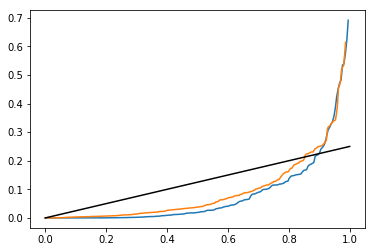

In [200]:
ontarget = {}
plt.figure()
keylist = list(soriavg.keys())
for i,key in enumerate(keylist):
    print(soriavg[key].shape)
    print(pval_fig[key].shape)
    ontarget[key] = pval_fig[key].min(1)<0.05/pval_fig[key].shape[1]
    lkat = np.logical_not(np.isnan(pval_fig[key]))
    plt.plot(np.arange(pval_fig[key].shape[0])/pval_fig[key].shape[0],np.sort(pval_fig[key].min(1)))
plt.plot((0,1),(0,0.25),c='k')

In [167]:
order = ['ctrl','fig','grnd','iso','cross']

In [189]:
ontarget = {}
for key in soriavg.keys():
    ontarget[key] = pval_fig[key].min(1)<0.05/pval_fig[key].shape[1]
    print(np.nanmin(pval_fig[key]))

9.70269261706e-12
2.12254265346e-08


/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [190]:
import retinotopy_analysis as rt
ontarget_ret_lax = {}
for key in soriavg.keys():
    ontarget_ret_lax[key],_ = rt.ontarget_by_retinotopy(ret_vars[key],ctr=ret_vars[key]['position'],rg=10)

/home/mossing/Documents/code/adesnal/retinotopy_analysis.py:260: RuntimeWarning: invalid value encountered in less
  return np.logical_and((xo+ctr_ret[0]-ctr[0])**2+(-yo+ctr_ret[1]-ctr[1])**2<rg**2,pval_ret<pcutoff),np.hstack((xo,yo))


In [170]:
keylist = list(soriavg.keys())

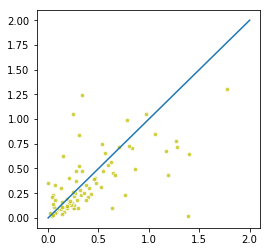

In [199]:
plt.figure(figsize=(4,4))
XX = np.array(())
YY = np.array(())


# plt.scatter(-1,-1,s=20,c='r',edgecolors='w',alpha=0.75)
# plt.scatter(-1,-1,s=20,c='b',edgecolors='w',alpha=0.5)
        
    
for key in keylist:
    lkat = ontarget_ret_lax[key]
    mx = soriavg[key][lkat].max()[np.newaxis]
    xx = soriavg[key][lkat,1]
    yy = soriavg[key][lkat,3]
    plt.scatter(xx,yy,s=20,c='y',edgecolors='w',alpha=0.75)

    
# plt.legend(['contrast-facilitated','contrast-suppressed'])

    
plt.plot((0,2),(0,2))
# plt.xlim(0,1.5)
# plt.ylim(0,1.5)
# plt.xlabel('inferred event rate ctrl')
# plt.ylabel('inferred event rate grnd')

#     XX = ut.add_to_array(XX,xx)
#     YY = ut.add_to_array(YY,yy)


matdict = {}
matdict['dataX'] = XX
matdict['dataY'] = YY
matdict['labelX'] = 'inferred event rate ctrl'
matdict['labelY'] = 'inferred event rate grnd'

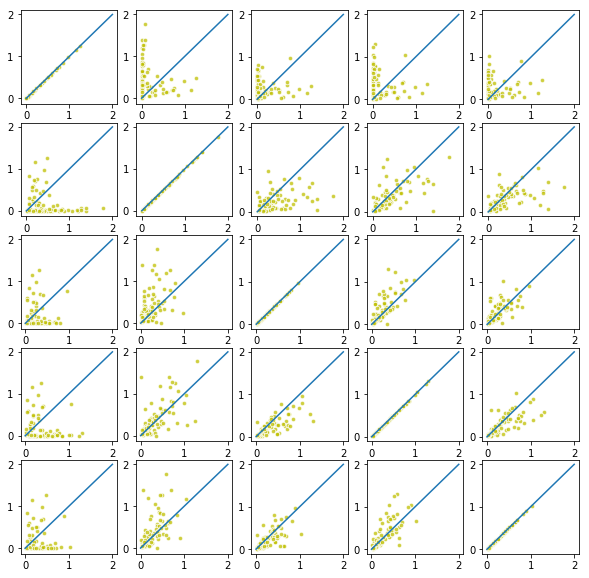

In [203]:
plt.figure(figsize=(10,10))
XX = np.array(())
YY = np.array(())


# plt.scatter(-1,-1,s=20,c='r',edgecolors='w',alpha=0.75)
# plt.scatter(-1,-1,s=20,c='b',edgecolors='w',alpha=0.5)
        
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        for key in keylist:
            lkat = ontarget_ret_lax[key]
            mx = soriavg[key][lkat].max()[np.newaxis]
            xx = soriavg[key][lkat,i]
            yy = soriavg[key][lkat,j]
            plt.scatter(xx,yy,s=20,c='y',edgecolors='w',alpha=0.75)


        # plt.legend(['contrast-facilitated','contrast-suppressed'])


        plt.plot((0,2),(0,2))
# plt.xlim(0,1.5)
# plt.ylim(0,1.5)
# plt.xlabel('inferred event rate ctrl')
# plt.ylabel('inferred event rate grnd')

#     XX = ut.add_to_array(XX,xx)
#     YY = ut.add_to_array(YY,yy)


matdict = {}
matdict['dataX'] = XX
matdict['dataY'] = YY
matdict['labelX'] = 'inferred event rate ctrl'
matdict['labelY'] = 'inferred event rate grnd'

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


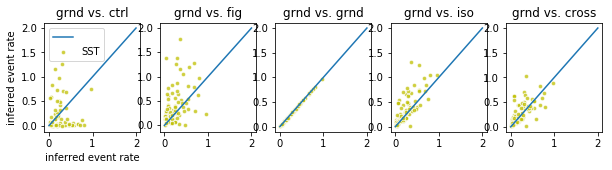

In [211]:
plt.figure(figsize=(10,2))
XX = np.array(())
YY = np.array(())


# plt.scatter(-1,-1,s=20,c='r',edgecolors='w',alpha=0.75)
# plt.scatter(-1,-1,s=20,c='b',edgecolors='w',alpha=0.5)
        
for j in range(5):
    plt.subplot(1,5,j+1)
    for key in keylist:
        lkat = ontarget_ret_lax[key]
        mx = soriavg[key][lkat].max()[np.newaxis]
        xx = soriavg[key][lkat,2]
        yy = soriavg[key][lkat,j]
        plt.scatter(xx,yy,s=20,c='y',edgecolors='w',alpha=0.75)


        # plt.legend(['contrast-facilitated','contrast-suppressed'])
    plt.title('grnd vs. '+ order[j])


    plt.plot((0,2),(0,2))
# plt.xlim(0,1.5)
# plt.ylim(0,1.5)
# plt.xlabel('inferred event rate ctrl')
# plt.ylabel('inferred event rate grnd')

#     XX = ut.add_to_array(XX,xx)
#     YY = ut.add_to_array(YY,yy)


matdict = {}
matdict['dataX'] = XX
matdict['dataY'] = YY
matdict['labelX'] = 'inferred event rate ctrl'
matdict['labelY'] = 'inferred event rate grnd'
plt.subplot(1,5,1)
plt.xlabel('inferred event rate')
plt.ylabel('inferred event rate')
plt.legend(['','SST'])
plt.savefig('sst_ground_stimulus.pdf')

In [204]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

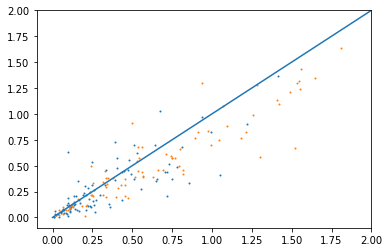

In [173]:
plt.figure()
XX = np.array(())
YY = np.array(())
for key in soriavg.keys():
    mx = 1 #soriavg[key][ontarget[key]].max()[np.newaxis]
    xx = soriavg[key][ontarget[key],3]/mx
    yy = soriavg[key][ontarget[key],4]/mx
    plt.scatter(xx,yy,s=1)
    XX = ut.add_to_array(XX,xx)
    YY = ut.add_to_array(YY,yy)
plt.plot((0,4),(0,4))
plt.xlim(-0.1,2)
plt.ylim(-0.1,2)

matdict = {}
matdict['dataX'] = XX
matdict['dataY'] = YY
matdict['labelX'] = 'inferred event rate iso-oriented'
matdict['labelY'] = 'inferred event rate cross-oriented'
# sio.savemat('updated_sst_iso_cross_non_norm.mat',matdict)

In [80]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

<IPython.core.display.Javascript object>


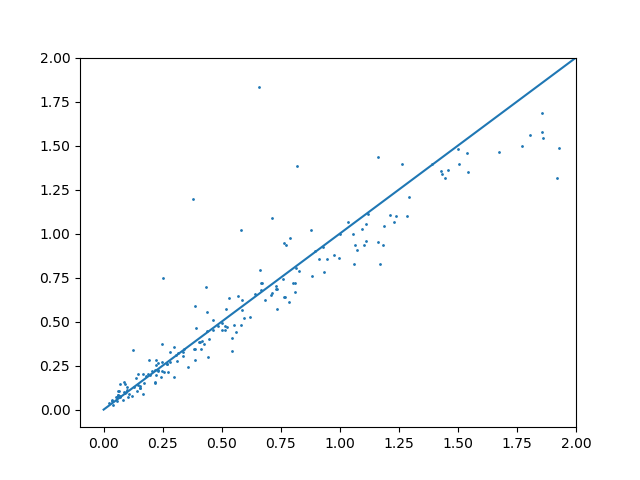

In [56]:
plt.figure()
XX = np.array(())
YY = np.array(())
for key in soriavg.keys():
    mx = 1 #soriavg[key][ontarget[key]].max()[np.newaxis]
    xx = soriavg[key][ontarget[key],2]/mx
    yy = soriavg[key][ontarget[key],4]/mx
    plt.scatter(xx,yy,s=1)
    XX = ut.add_to_array(XX,xx)
    YY = ut.add_to_array(YY,yy)
plt.plot((0,4),(0,4))
plt.xlim(-0.1,2)
plt.ylim(-0.1,2)

matdict = {}
matdict['dataX'] = XX
matdict['dataY'] = YY
matdict['labelX'] = 'inferred event rate iso-oriented'
matdict['labelY'] = 'inferred event rate cross-oriented'

In [81]:
lb[thisfold].shape

(300, 5, 8)

In [82]:
strialavg[thisfold].shape

(300, 5, 4, 12)

In [101]:
def plot_errorbars(x,mn_tgt,lb_tgt,ub_tgt):
    errorplus = ub_tgt-mn_tgt
    errorminus = mn_tgt-lb_tgt
    errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
    for i in range(mn_tgt.shape[0]):
        plt.errorbar(x,mn_tgt[i],yerr=errors[:,i,:],alpha=0.5)

In [122]:
ret[thisfold].shape

(287, 9, 9)

<IPython.core.display.Javascript object>


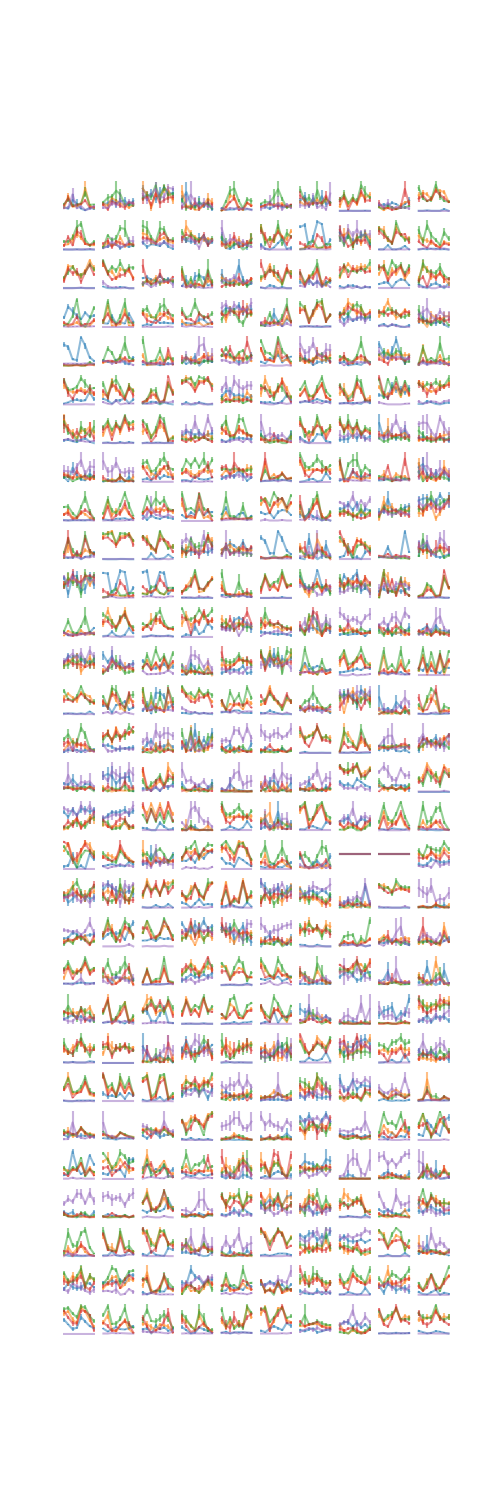

In [124]:
plt.figure(figsize=(5,15))
inds_to_compare = np.array((1,2,3,4,0))
for k in range(300):
    plt.subplot(30,10,k+1)
    plot_errorbars(np.arange(0,360,45),mn[thisfold][k,inds_to_compare],lb[thisfold][k,inds_to_compare],ub[thisfold][k,inds_to_compare])
    plt.axis('off')

<IPython.core.display.Javascript object>


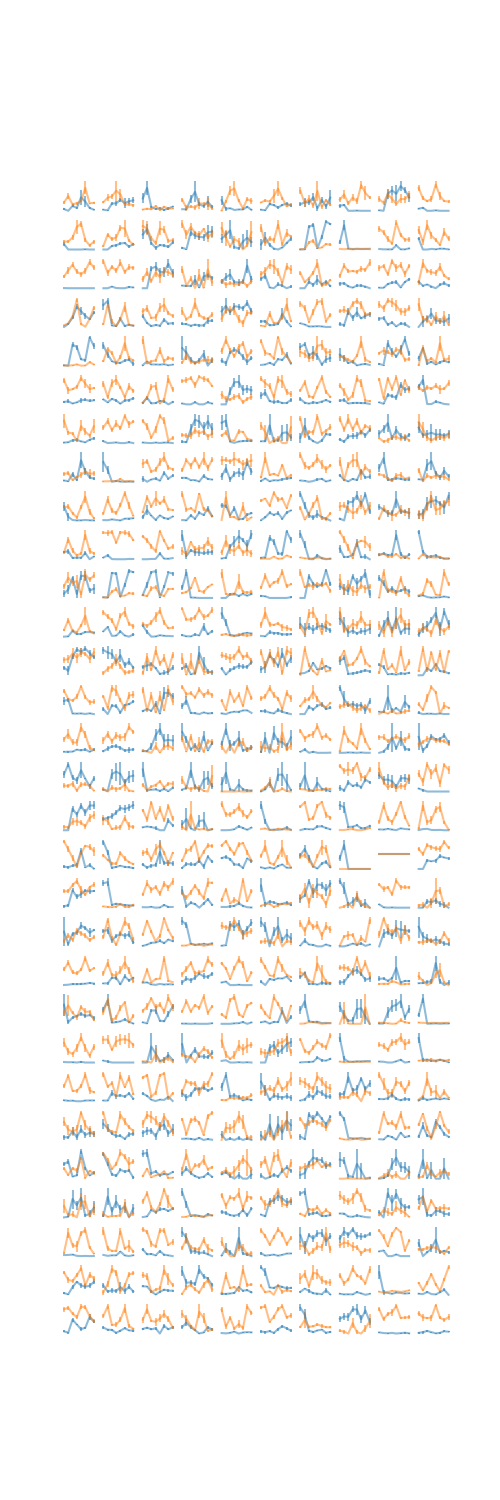

In [197]:
plt.figure(figsize=(5,15))
inds_to_compare = np.array((1,3))
temp1 = np.roll(mn[thisfold][:,inds_to_compare[0:1]],(0,0,2))
temp1lb = np.roll(lb[thisfold][:,inds_to_compare[0:1]],(0,0,2))
temp1ub = np.roll(ub[thisfold][:,inds_to_compare[0:1]],(0,0,2))
temp2 = np.roll(mn[thisfold][:,inds_to_compare[1:2]],(0,0,0))
temp2lb = np.roll(lb[thisfold][:,inds_to_compare[1:2]],(0,0,0))
temp2ub = np.roll(ub[thisfold][:,inds_to_compare[1:2]],(0,0,0))
for k in range(mn[thisfold].shape[0]):
    plt.subplot(30,10,k+1)
    plot_errorbars(np.arange(0,360,45),temp1[k],temp1lb[k],temp1ub[k])
    plot_errorbars(np.arange(0,360,45),temp2[k],temp2lb[k],temp2ub[k])
#     plot_errorbars(np.arange(0,360,45),mn[thisfold][k,0:1],lb[thisfold][k,0:1],ub[thisfold][k,0:1])
    plt.axis('off')
#     if np.remainder(k,10)==0:
#         plt.axis('on')
#         plt.ylabel(k)

<IPython.core.display.Javascript object>


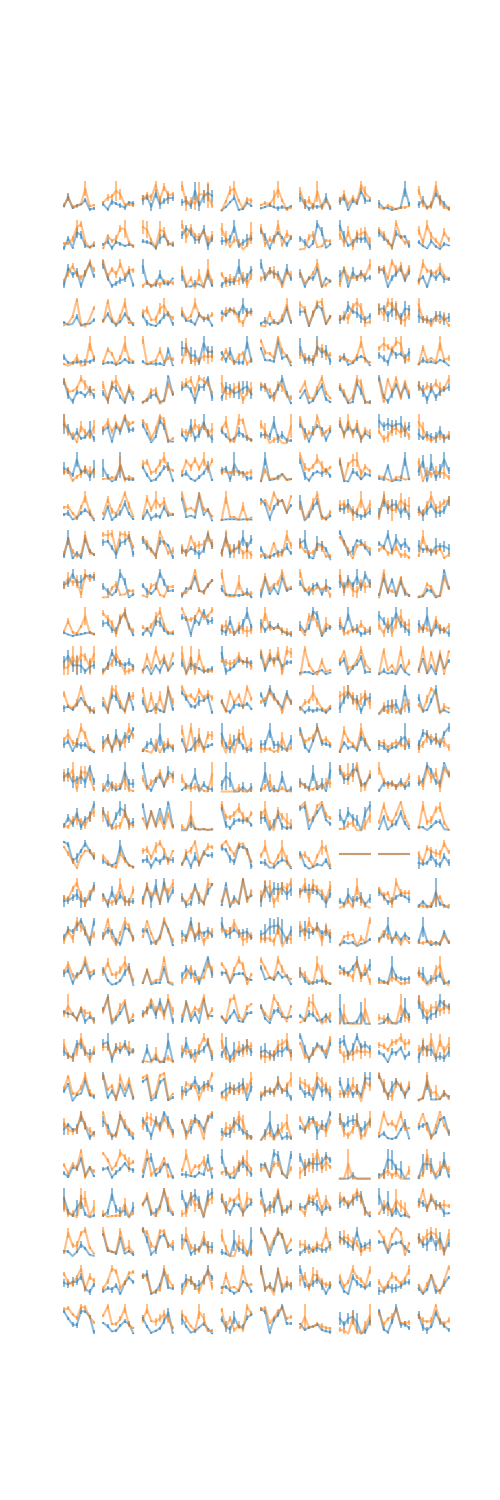

In [199]:
plt.figure(figsize=(5,15))
inds_to_compare = np.array((4,3))
for k in range(mn[thisfold].shape[0]):
    plt.subplot(30,10,k+1)
    plot_errorbars(np.arange(0,360,45),mn[thisfold][k,inds_to_compare],lb[thisfold][k,inds_to_compare],ub[thisfold][k,inds_to_compare])
    plt.axis('off')

In [185]:
temp1.shape

(1, 8)

In [181]:
mn[thisfold].shape

(300, 5, 8)

<IPython.core.display.Javascript object>


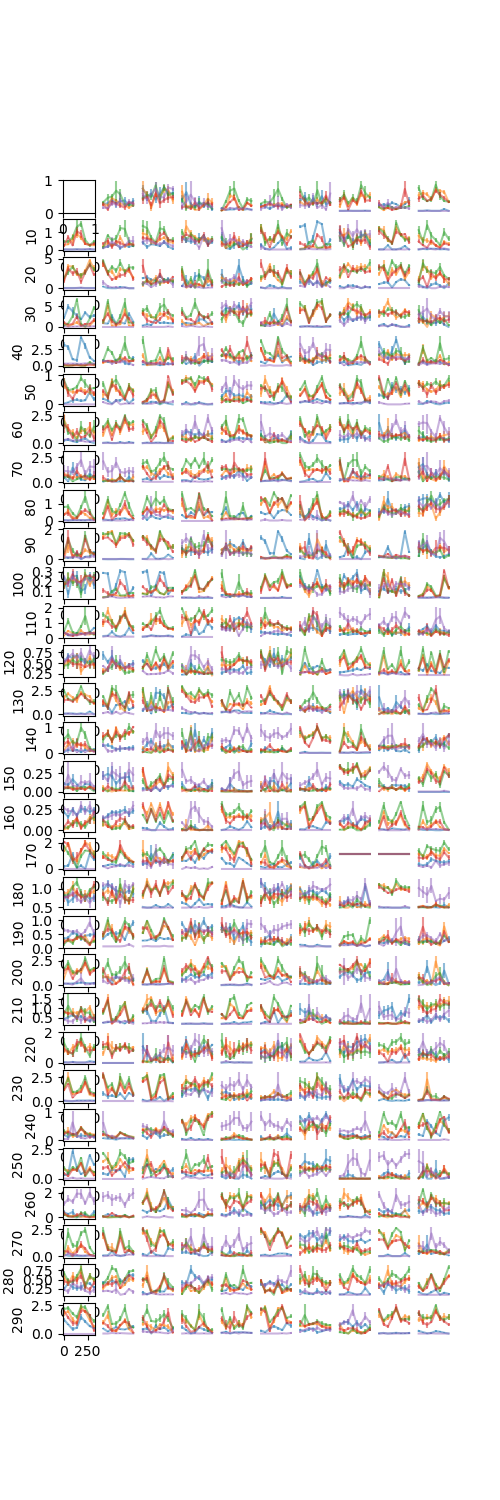

In [137]:
# plt.figure(figsize=(5,15))
inds_to_compare = np.array((1,2,3,4,0))
rowlen = 10
nrows = np.ceil(mn[thisfold].shape[0]/rowlen)
scale = 0.5
plt.figure(figsize=(scale*rowlen,scale*nrows))
for k in range(mn[thisfold].shape[0]):
    plt.subplot(nrows,rowlen,k+1)
    plot_errorbars(np.arange(0,360,45),mn[thisfold][k,inds_to_compare],lb[thisfold][k,inds_to_compare],ub[thisfold][k,inds_to_compare])
    plt.axis('off')
    if np.remainder(k,rowlen)==0:
        plt.axis('on')
        plt.ylabel(k)

In [173]:
def imshow_in_rows(arr,rowlen=10,scale=0.5,com=None):
    nrows = np.ceil(arr.shape[0]/rowlen)
    plt.figure(figsize=(scale*rowlen,scale*nrows))
    for k in range(arr.shape[0]):
        plt.subplot(nrows,rowlen,k+1)
        plt.imshow(arr[k])
        plt.axis('off')
        if np.remainder(k,rowlen)==0:
            plt.axis('on')
            plt.ylabel(k)
        if not com is None:
            plt.scatter(com[k,1],com[k,0],c='m',marker='+')

In [174]:
com = np.zeros((ret[thisfold].shape[0],2))
rowlen = 10
nrows = np.ceil(ret[thisfold].shape[0]/rowlen)
for i in range(ret[thisfold].shape[0]):
    com[i] = snm.center_of_mass(ut.norm01(ret[thisfold][i],dim=None))

/home/mossing/Documents/code/adesnal/pyute.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (arr-mnm)/(mxm-mnm)


<IPython.core.display.Javascript object>


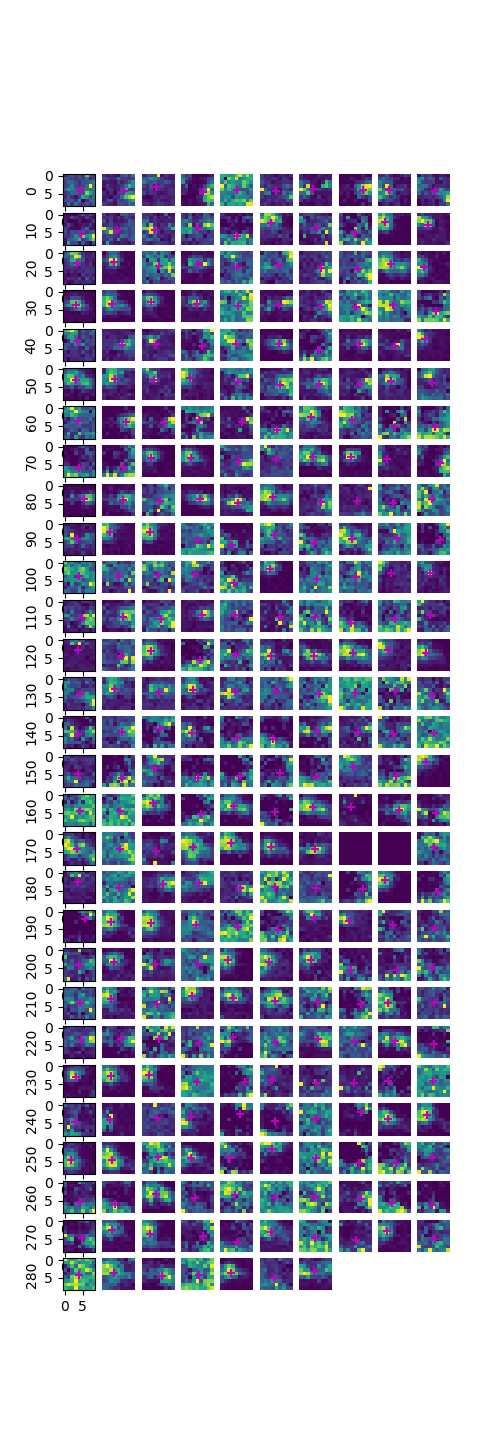

In [175]:
imshow_in_rows(ret[thisfold],com=com)

In [162]:
com[0]

array([ 4.01112868,  4.36239369])